In [1]:
%pip install geoopt
%pip install pyvis

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2025-04-17 17:12:06--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

     0K .......... .......... .......... .......... ..........  0%  181K 32s
    50K .......... .......... .......... .......... ..........  1%  361K 24s
   100K .......... .......... .......... .......... ..........  2% 59.3M 16s
   150K .......... .......... .......... .......... ..........  3%  361K 15s
   200K .......... .......... .......... .......... ..........  4% 91.1M 12s
   250K .......... .......... .......... .......... ..........  5% 61.1M 10s
   300K .......... .......... .......... .......... ..........  6%  363K 11s
   350K .......... .......... .......... .......... ..........  6%  192M 9s
   400K .......... ..........

Archive:  ml-1m.zip


replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


Exception: Process exited with code 1

In [44]:
import json
import os

import torch
import numpy as np
import pandas as pd
import geoopt
from tqdm import tqdm
from torch import nn
import torch.utils.data as td
from tqdm import trange
import scipy

In [45]:
# DATA_DIR = './data/ml1m'
DATA_DIR = './data/pinterest'

In [4]:
from torch.distributions.categorical import Categorical

class TreeDataset(td.Dataset):
    def __init__(self, interactions, num_negatives):
        super().__init__()
        self.num_negatives = num_negatives
        sums = torch.sum(interactions, dim=0)
        items_sims = (interactions.T @ interactions) / torch.pow(sums[:, None] * sums[None, :], 0.2)
        # items_sims = torch.tensor((interactions.T @ interactions).todense()) - (sums[:, None] * sums[None, :]) / sums.shape[0]**1.3
        # items_dist = (sums[:, None] + sums[None, :]) - 2 * items_sims
        # items_dist = torch.log1p(sums[:, None] - items_sims) + torch.log1p(sums[None, :] - items_sims)
        items_dist = 1 / (items_sims + 1)

        #MST
        self.num_vertex = items_sims.shape[0]
        self.mst_edges = [[] for _ in range(self.num_vertex)]
        vis = torch.zeros(self.num_vertex, dtype=torch.int64)
        first_v = torch.argmax(sums).item()
        min_edge = torch.full((self.num_vertex,), first_v, dtype=torch.int64)
        vis[first_v] = 1
        self.edges_list = []
        arange = torch.arange(self.num_vertex)
        for _ in trange(1, self.num_vertex):
            dists = items_dist[min_edge[arange], arange]
            dists[vis == 1] = torch.inf
            cur_v = torch.argmin(dists).item()
            vis[cur_v] = 1
            self.mst_edges[min_edge[cur_v].item()].append(cur_v)
            min_edge[items_dist[min_edge[arange], arange] > items_dist[cur_v, arange]] = cur_v


        #Transitive closure
        def dfs(x):
            subtree = []
            for v in self.mst_edges[x]:
                subtree += dfs(v)
            self.edges_list += [(v, x) for v in subtree]
            return subtree + [x]
        
        dfs(first_v)
        
        self.neighbours = torch.zeros(self.num_vertex, self.num_vertex, dtype=torch.bool)
        for u, v in self.edges_list:
            self.neighbours[u, v] = 1
        self.neighbours[torch.arange(self.num_vertex, dtype=torch.int32), torch.arange(self.num_vertex, dtype=torch.int32)] = 1

        self.burnin = True
        self.counts = torch.zeros(self.num_vertex)
        for edge in self.edges_list:
            self.counts[edge[1]] += 1
        

    def __len__(self):
        return len(self.edges_list)
    
    def __getitem__(self, index):
        edge = self.edges_list[index]
        pos_ind = edge[1]
        if self.burnin:
            counts = self.counts.clone()
            counts[self.neighbours[edge[0]]] = 0
        else:
            counts = 1 - (self.neighbours[edge[0]]).to(torch.float32)
        neg_dist = Categorical(probs=counts / torch.sum(counts))
        neg_inds = neg_dist.sample((self.num_negatives,))
        return torch.cat((torch.tensor([pos_ind]), neg_inds)), edge[0]

In [3]:
interactions_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), names=['userId', 'itemId', 'rating', 'timestamp'], delimiter='::', engine='python')
interactions_data = interactions_data.rename(columns={'userId': 'user_id', 'itemId': 'item_id'})
interactions_data = interactions_data.drop('rating', axis=1)

item_data = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'), names=['MovieID', 'Title', 'Genres'], delimiter='::', encoding="ISO-8859-1", engine='python')
item_data = item_data.rename(columns={'MovieID': 'item_id'})

In [66]:
interactions_data = pd.read_csv(os.path.join(DATA_DIR, 'pinterest.csv'))
interactions_data = interactions_data.rename(columns={'board_id': 'user_id', 'image': 'item_id'})

items_freqs = interactions_data.groupby('item_id').count().reset_index()
items = items_freqs[items_freqs['user_id'] > 10]["item_id"]
interactions_data = interactions_data[interactions_data['item_id'].isin(items)]

In [4]:
timestamps = np.array(interactions_data['timestamp'])
val_separator = np.quantile(timestamps, 0.9, method='lower')
test_separator = np.quantile(timestamps, 0.95, method='lower')

unique_items = pd.unique(interactions_data[interactions_data['timestamp'] < val_separator]['item_id'])
item2idx = {item_id: i for i, item_id in enumerate(unique_items)}

item_data = item_data[item_data['item_id'].isin(unique_items)]
interactions_data = interactions_data[interactions_data['item_id'].isin(unique_items)]

interactions_data.loc[:, 'item_id'] = interactions_data['item_id'].apply(lambda x: item2idx[x])
item_data.loc[:, 'item_id'] = item_data['item_id'].apply(lambda x: item2idx[x])

unique_users = pd.unique(interactions_data['user_id'])
user2idx = {user_id: i for i, user_id in enumerate(unique_users)}

interactions_data.loc[:, 'user_id'] = interactions_data['user_id'].apply(lambda x: user2idx[x])

In [71]:
unique_items = pd.unique(interactions_data['item_id'])
item2idx = {item_id: i for i, item_id in enumerate(unique_items)}

item_data = item_data[item_data['item_id'].isin(unique_items)]
interactions_data = interactions_data[interactions_data['item_id'].isin(unique_items)]

interactions_data.loc[:, 'item_id'] = interactions_data['item_id'].apply(lambda x: item2idx[x])
item_data.loc[:, 'item_id'] = item_data['item_id'].apply(lambda x: item2idx[x])

unique_users = pd.unique(interactions_data['user_id'])
user2idx = {user_id: i for i, user_id in enumerate(unique_users)}

interactions_data.loc[:, 'user_id'] = interactions_data['user_id'].apply(lambda x: user2idx[x])

/var/folders/4b/q18n24nj30sf75y98wqt3rr00000gn/T/ipykernel_23841/2353751083.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  interactions_data.loc[:, 'item_id'] = interactions_data['item_id'].apply(lambda x: item2idx[x])


In [73]:
interaction_matrix = torch.zeros(len(user2idx), len(item2idx))
interactions = interactions_data
interaction_matrix[interactions['user_id'].values, interactions['item_id'].values] = 1

In [78]:
interaction_matrix.shape

torch.Size([45635, 32049])

In [8]:
tree_dataset = TreeDataset(interaction_matrix, 10)

100%|██████████| 3677/3677 [00:00<00:00, 12428.73it/s]


In [9]:
import matplotlib as mpl

def colorFader(c1, c2, mix=0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1 - mix) * c1 + mix * c2)

In [79]:
num_interactions = torch.sum(interaction_matrix, dim=0)

In [13]:
from pyvis.network import Network

c1 = 'blue'
c2 = 'green'

net = Network(notebook = True, cdn_resources='in_line',
                bgcolor = "#222222",
                font_color = "white",
                height = "100%",
                width = "100%",
)
# net.toggle_physics(False)
nodes = list(range(interaction_matrix.shape[1]))
edges = [(v, i) for i, ls in enumerate(tree_dataset.mst_edges) for v in ls]
net.add_nodes(nodes, label=item_data['Title'].tolist(), color=[colorFader(c1, c2, (x / torch.max(num_interactions)).numpy()) for x in num_interactions])
net.add_edges(edges)

# for n in net.nodes:
#     n.update({'physics': False})

net.show_buttons(filter_=["physics"])
net.save_graph('a.html')

In [74]:
from torch.distributions.categorical import Categorical

class SimilarityDataset(td.Dataset):
    def __init__(self, items_sims, num_negatives):
        super().__init__()
        num_items = items_sims.shape[0]
        items_sims[torch.arange(num_items), torch.arange(num_items)] = 0
        self.num_negatives = num_negatives
        sorted_sims, self.sorted_inds = torch.sort(items_sims, dim=1)

        self.less_inds = torch.searchsorted(sorted_sims, sorted_sims, right=False)
        
        self.max_item_size = 1000

        self.users_thresholds = torch.cumsum(torch.minimum(torch.count_nonzero(self.less_inds, dim=1), torch.tensor([self.max_item_size])), dim=0)
        
        self.burnin = True
        self.counts = torch.sum(items_sims, dim=0)

    def __len__(self):
        return self.users_thresholds[-1]
    
    def set_max_item_size(self, max_items_size):
        self.max_item_size = max_items_size

        self.users_thresholds = torch.cumsum(torch.minimum(torch.count_nonzero(self.less_inds, dim=1), torch.tensor([max_items_size])), dim=0)
    
    def __getitem__(self, index):
        item_ind = torch.searchsorted(self.users_thresholds, index, right=True)
        ind = self.users_thresholds[item_ind] - index
        positive_ind = torch.tensor([self.sorted_inds[item_ind, -ind]])
        less_ind = self.less_inds[item_ind, -ind]
        if self.burnin:
            counts = self.counts.clone()
        else:
            counts = torch.ones(self.less_inds.shape[0])
        counts[self.sorted_inds[item_ind, less_ind:]] = 0
        counts[item_ind] = 0
        # assert torch.sum(counts) > 0, less_ind
        neg_inds = Categorical(probs=counts / torch.sum(counts)).sample((self.num_negatives,))
        return torch.cat((positive_ind, neg_inds)), item_ind

In [80]:
items_sims = (interaction_matrix.T @ interaction_matrix) / torch.pow(interaction_matrix.shape[1] + num_interactions[None, :], 1.0)
# items_sims[items_sims < torch.quantile(items_sims.flatten(), 0.95)] = 0.0
dataset = SimilarityDataset(items_sims, 15)

In [171]:
torch.quantile(items_sims.flatten(), 0.9)

tensor(3.6293e-06)

In [181]:
items_sims = (interaction_matrix.T @ interaction_matrix) / torch.pow(interaction_matrix.shape[1] + num_interactions[None, :], 2.0)
items_sims[items_sims < torch.quantile(items_sims.flatten(), 0.99)] = 0.0

In [202]:
torch.sort(num_interactions).values[2000]

tensor(133.)

In [183]:
torch.count_nonzero(items_sims)

tensor(135285)

(array([3.137e+03, 5.400e+01, 3.400e+01, 2.500e+01, 3.100e+01, 1.700e+01,
        1.400e+01, 1.100e+01, 2.000e+01, 8.000e+00, 1.500e+01, 1.000e+01,
        6.000e+00, 3.000e+00, 8.000e+00, 8.000e+00, 8.000e+00, 7.000e+00,
        8.000e+00, 6.000e+00, 8.000e+00, 4.000e+00, 7.000e+00, 8.000e+00,
        5.000e+00, 9.000e+00, 5.000e+00, 7.000e+00, 9.000e+00, 4.000e+00,
        8.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 9.000e+00, 4.000e+00,
        4.000e+00, 1.000e+01, 3.000e+00, 6.000e+00, 9.000e+00, 7.000e+00,
        3.000e+00, 5.000e+00, 7.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        5.000e+00, 8.000e+00, 4.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 6.000e+00,
        1.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+0

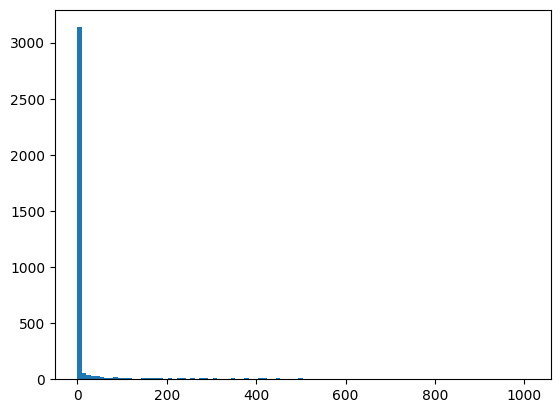

In [184]:
plt.hist(torch.count_nonzero(items_sims, dim=1), bins=100)

In [81]:
class PoincareEmbedding(nn.Module):
    def __init__(self, num_items, emb_dim, manifold):
        super().__init__()
        init_tensor = torch.rand(num_items, emb_dim, dtype=torch.float64) * 0.002 - 0.001
        if isinstance(manifold, geoopt.Lorentz):
            init_tensor = torch.cat((torch.sqrt(torch.sum(init_tensor**2, dim=1, keepdim=True) + manifold.k), init_tensor), dim=1)
        self.matrix = geoopt.ManifoldParameter(init_tensor, manifold=manifold, requires_grad=True)
        self.manifold = manifold
    
    def forward(self, x):
        items, origin_item = x
        dist = -self.manifold.dist(self.matrix[items], self.matrix[origin_item].unsqueeze(dim=1))
        assert not torch.any(torch.isnan(dist))
        return dist

In [82]:
def train(loader, model, optimizer, scheduler, criterion, show_progress=True):
    model.train()
    epoch_loss = 0.0

    iterable = loader
    if show_progress:
        iterable = tqdm(iterable)
        
    max_grad = 0.0
    max_val = 0.0
    
    for batch in iterable:
        optimizer.zero_grad()
        logits = model((batch[0].to(device), batch[1].to(device)))
        loss = criterion(logits, torch.zeros(logits.shape[0], dtype=torch.int64).to(device))
        # print(logits)
        loss.backward()
        optimizer.step()
        max_val = max(max_val, torch.max(torch.abs(model.matrix)).item())
        max_grad = max(max_grad, torch.norm(model.matrix.grad).item())
        assert not torch.any(torch.isnan(model.matrix))
        model.matrix.data = model.manifold.projx(model.matrix.data)
        # model.matrix.data = model.manifold.projx(model.matrix.data * torch.minimum(torch.tensor(1.0, dtype=torch.float64, device=device), 1e6 / torch.norm(model.matrix.data, dim=1, keepdim=True)))
        # model.manifold.assert_check_point_on_manifold(model.matrix)
        epoch_loss += loss.item() * loader.batch_size

    scheduler.step()
    
    return epoch_loss / len(loader.dataset), max_val, max_grad

100%|██████████| 2504/2504 [00:48<00:00, 51.34it/s]


Epoch 0: loss=2.7731278652011597
0.0036465603003186862
0.36925612163624305


100%|██████████| 2504/2504 [00:51<00:00, 49.01it/s]


Epoch 1: loss=2.7725830907014846
0.006309874292028171
0.3602513656978723


100%|██████████| 2504/2504 [00:47<00:00, 52.38it/s]


Epoch 2: loss=2.7719987622966613
0.009788303857799628
0.37357665508550136


100%|██████████| 2504/2504 [00:48<00:00, 51.85it/s]


Epoch 3: loss=2.7713791175253726
0.012722572715405871
0.38608702410853335


100%|██████████| 2504/2504 [00:48<00:00, 51.91it/s]
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


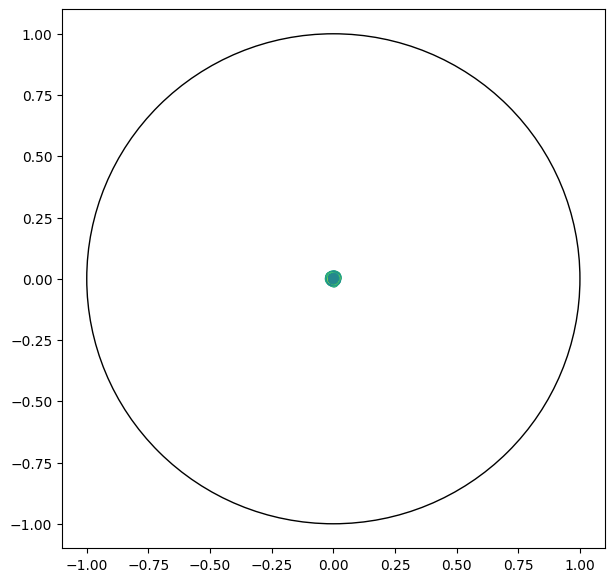

Epoch 4: loss=2.770717432526535
0.016319714446276723
0.39805464656283346


100%|██████████| 2504/2504 [00:47<00:00, 52.21it/s]


Epoch 5: loss=2.622401277591856
0.9175210724494578
0.4156258706673173


100%|██████████| 2504/2504 [00:47<00:00, 53.17it/s]


Epoch 6: loss=2.0366384860201476
0.9859322752859516
0.6255237063829394


100%|██████████| 2504/2504 [00:48<00:00, 52.02it/s]


Epoch 7: loss=1.5350746920542366
0.9940696288137656
1.0325167620239086


100%|██████████| 2504/2504 [00:47<00:00, 52.92it/s]


Epoch 8: loss=1.2297070395534775
0.9983598243370227
1.8924534740018224


100%|██████████| 2504/2504 [00:48<00:00, 51.40it/s]


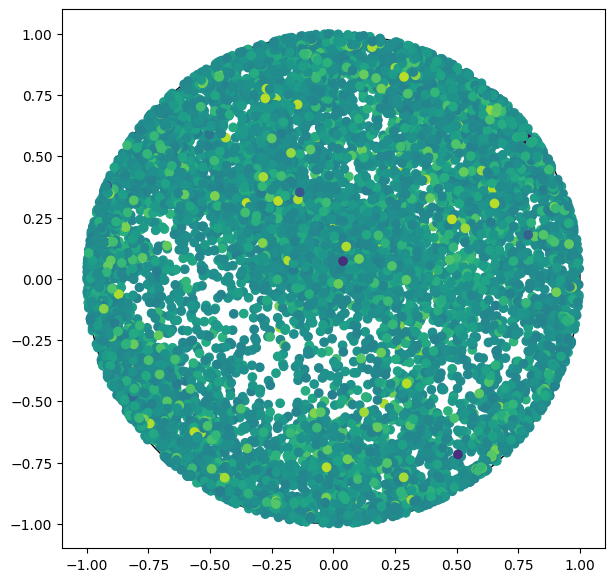

Epoch 9: loss=1.0554421858085052
0.9992354773562254
3.985641294564143


100%|██████████| 2504/2504 [00:48<00:00, 51.68it/s]


Epoch 10: loss=0.9522435869885855
0.9995801413401644
4.198718354499635


100%|██████████| 2504/2504 [00:48<00:00, 52.12it/s]


Epoch 11: loss=0.8850890485793677
0.999753875307039
14.875685478203136


100%|██████████| 2504/2504 [00:48<00:00, 52.17it/s]


Epoch 12: loss=0.839607006765561
0.9998189729906113
32.32491423225561


100%|██████████| 2504/2504 [00:48<00:00, 51.78it/s]


Epoch 13: loss=0.8086334575854376
0.9998751651180956
172.55627335358608


100%|██████████| 2504/2504 [00:48<00:00, 52.11it/s]


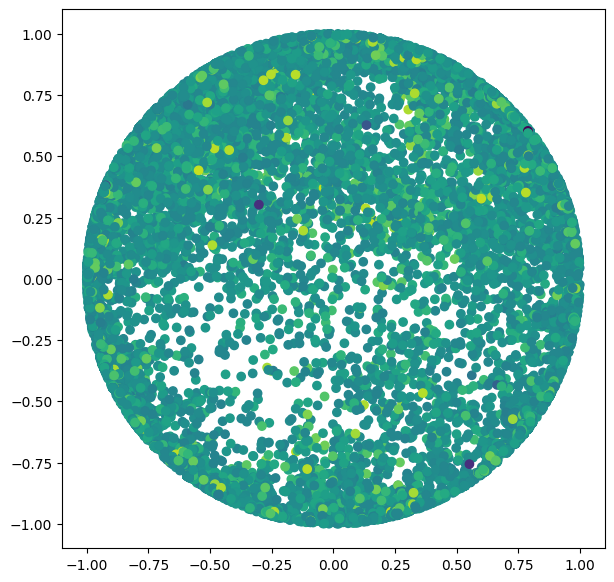

Epoch 14: loss=0.7838190014326221
0.9999057135440317
776.3739003977324


100%|██████████| 2504/2504 [00:48<00:00, 51.15it/s]


Epoch 15: loss=0.7659988228562706
0.9999338707674548
780.4412273448255


100%|██████████| 2504/2504 [00:48<00:00, 51.23it/s]


Epoch 16: loss=0.7530620701658345
0.9999482774866956
780.8702139386437


100%|██████████| 2504/2504 [00:48<00:00, 51.57it/s]


Epoch 17: loss=0.7440241442317229
0.9999551547692395
861.5603901311883


100%|██████████| 2504/2504 [00:48<00:00, 51.32it/s]


Epoch 18: loss=0.7366258591969257
0.9999522627354824
1521.5675837104595


100%|██████████| 2504/2504 [00:48<00:00, 51.95it/s]


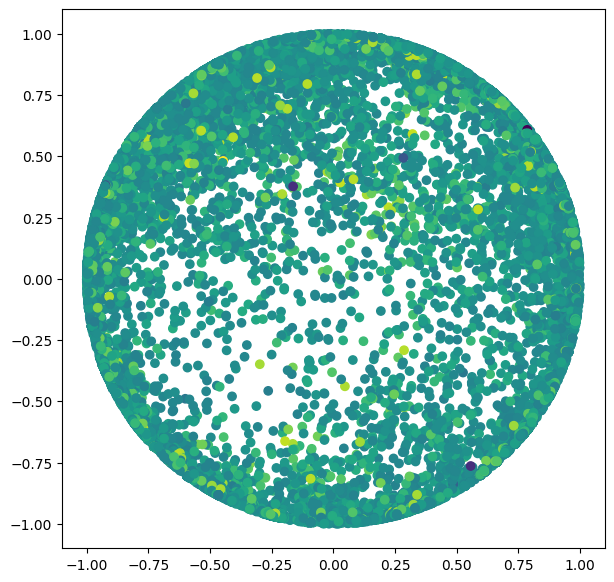

Epoch 19: loss=0.7292133870245454
0.999960901280096
1065.2450826439303


100%|██████████| 2504/2504 [00:49<00:00, 50.73it/s]


Epoch 20: loss=0.7237872982558742
0.9999651799923586
1098.5136521929571


100%|██████████| 2504/2504 [00:52<00:00, 47.42it/s]


Epoch 21: loss=0.7200053942173148
0.9999716830950981
1300.9142219273022


100%|██████████| 2504/2504 [00:50<00:00, 49.63it/s]


Epoch 22: loss=0.7180559894585102
0.9999603698600924
1325.674810140411


100%|██████████| 2504/2504 [00:48<00:00, 51.13it/s]


Epoch 23: loss=0.71533819871776
0.9999468534539103
1096.4314325558469


100%|██████████| 2504/2504 [00:49<00:00, 50.73it/s]


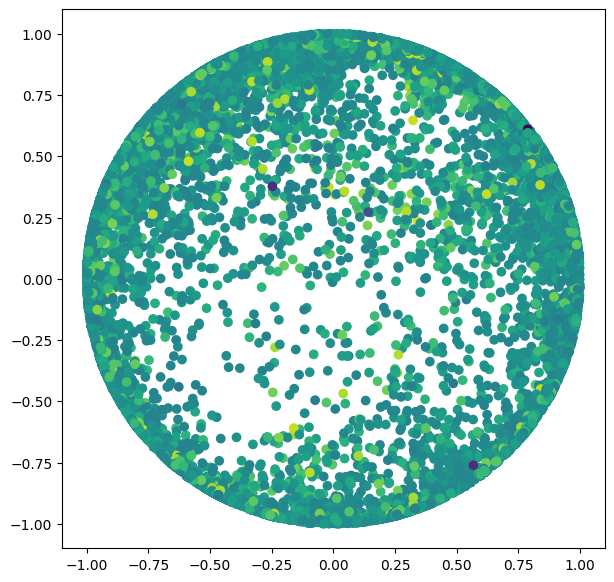

Epoch 24: loss=0.71372608820669
0.9999468534521133
1098.6430556017708


 19%|█▉        | 482/2504 [00:09<00:41, 49.00it/s]


KeyboardInterrupt: 

In [85]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
c = torch.tensor(1.0, dtype=torch.float64)
burn_in_epochs = 5
epochs = 300
manifold = geoopt.PoincareBall(c)
# manifold = geoopt.Lorentz(c)
model = PoincareEmbedding(interaction_matrix.shape[1], 2, manifold).to(device)
optimizer = geoopt.optim.RiemannianAdam(model.parameters(), 1e-2, eps=1e-15, weight_decay=1e-12)
# optimizer = geoopt.optim.RiemannianSGD(model.parameters(), 1.0)

train_loader = td.DataLoader(dataset, batch_size=128, shuffle=True, pin_memory=True)
scheduler1 = ConstantLR(optimizer, factor=0.001, total_iters=burn_in_epochs)
scheduler2 = LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=epochs - burn_in_epochs)
scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[burn_in_epochs])

# max_items_sizes = [1000, 500, 250, 200, 150, 125, 100, 75, 60, 50, 30, 15]
max_items_sizes = [10] * 300

train_loader.dataset.burnin = True

for epoch in range(epochs):
    train_loader.dataset.set_max_item_size(max_items_sizes[epoch])
    loss, max_val, max_grad = train(train_loader, model, optimizer, scheduler, nn.CrossEntropyLoss().to(device), show_progress=True)
    if epoch == burn_in_epochs - 1:
        train_loader.dataset.burnin = False
    if epoch % 5 == 4:
        fig, ax = plt.subplots(figsize=(7, 7))
    
        embs = model.matrix
        if isinstance(model.manifold, geoopt.Lorentz):
            embs = geoopt.manifolds.lorentz.math.lorentz_to_poincare(embs, model.manifold.k, dim=1)
        ax.add_patch(plt.Circle((0, 0), 1.0, ec='black', fill=False))
        ax.scatter(embs[:, 0].cpu().detach().numpy(), embs[:, 1].cpu().detach().numpy(), c=num_interactions, norm='log')
        # fig.colorbar(cm.ScalarMappable(), orientation="vertical")
        plt.show()
    
    print(f"Epoch {epoch}: loss={loss}")
    print(max_val)
    print(max_grad)

In [88]:
categories = []
with open("data/pinterest/categories.txt") as f:
    for line in f:
        categories.append(line[:-1])

In [ ]:
import bson

with open("data/pinterest/subset_iccv_board_cate",'rb') as f:
    data = bson.decode_all(f.read())

main_df=pd.DataFrame(data)

In [19]:
from pyvis.network import Network

c1 = 'blue'
c2 = 'green'

net = Network(notebook = True, cdn_resources='in_line',
                bgcolor = "#222222",
                font_color = "white",
                height = "100%",
                width = "100%",
              filter_menu=True
)
inds = item_data.sort_values(by=['item_id'])['Genres'].str.contains('Comedy').values
nodes = list(torch.arange(interaction_matrix.shape[1])[inds])
edges = [(v, i) for i, ls in enumerate(tree_dataset.mst_edges) for v in ls if v in nodes and i in nodes]
# edges = tree_dataset.mst_edges
x = model.matrix[inds, 0].detach().cpu().numpy() * 10000
y = model.matrix[inds, 1].detach().cpu().numpy() * 10000
net.add_nodes(nodes, label=item_data.sort_values(by=['item_id'])[inds]['Title'].tolist(), x=list(map(float, x)), y=list(map(float, y)), color=[colorFader(c1, c2, (x / torch.max(num_interactions)).numpy()) for x in num_interactions[inds]])
net.add_edges(edges)
for n in net.nodes:
    n.update({'physics': False})

net.show_buttons(filter_=["physics"])
net.save_graph('a.html')

NameError: name 'tree_dataset' is not defined

In [17]:
len([(v, i) for i, ls in enumerate(tree_dataset.mst_edges) for v in ls])

3677

In [18]:
len(edges)

3677

In [287]:
net.get_node(1)

{'color': '#97c2fc',
 'x': 7897.4404296875,
 'y': 6029.63134765625,
 'id': 1,
 'label': 'Jumanji (1995)',
 'shape': 'dot',
 'font': {'color': 'white'},
 'physics': False}

In [216]:
from IPython.display import display, HTML
  
with open('a.html', 'r') as file:
    html_content = file.read()
    
# display(HTML(html_content))

In [105]:
inds = items.apply(lambda x: item2idx[x]).values

In [106]:
inds

array([31868,  1082, 25418, ..., 12688, 30785,  7810])

In [179]:
item_data[item_data['item_id'] == 94]

item_id                                              Title  \
1178       94  Star Wars: Episode V - The Empire Strikes Back...   

                                 Genres  
1178  Action|Adventure|Drama|Sci-Fi|War

In [104]:
embs

Parameter on PoincareBall manifold containing:
Parameter(ManifoldParameter([[-0.2918,  0.7032],
                   [ 0.0673,  0.9885],
                   [-0.6326,  0.2680],
                   ...,
                   [ 0.7603, -0.6390],
                   [-0.7157,  0.6975],
                   [-0.0892,  0.9952]], dtype=torch.float64,
                  requires_grad=True))

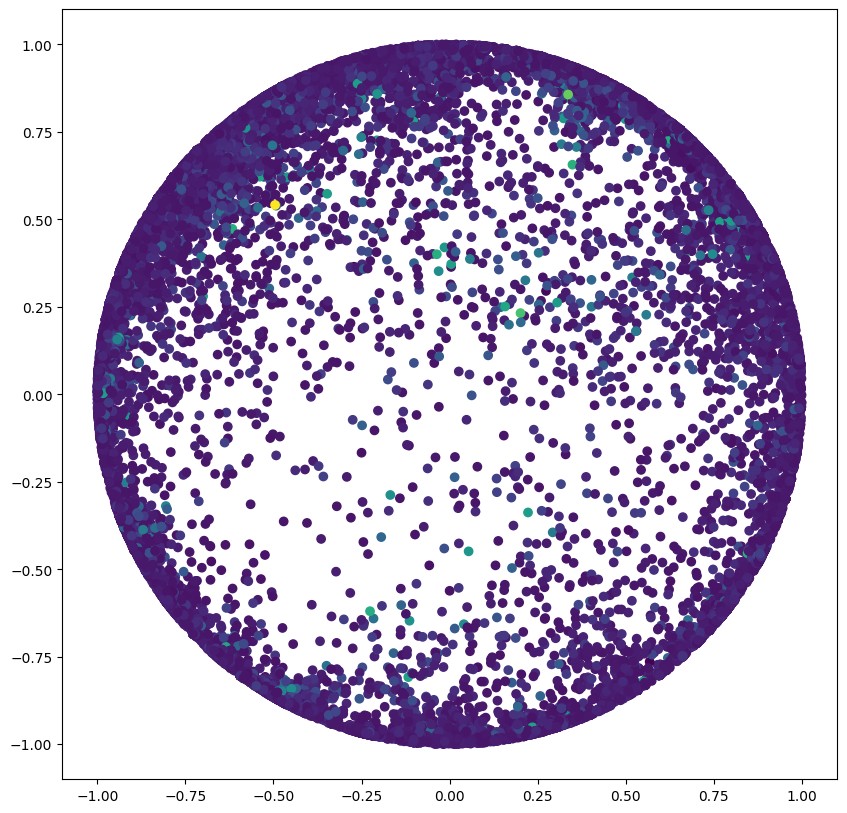

In [108]:
embs = model.matrix
if isinstance(model.manifold, geoopt.Lorentz):
    embs = geoopt.manifolds.lorentz.math.lorentz_to_poincare(embs, model.manifold.k, dim=1)

fig, ax = plt.subplots(figsize=(10, 10))

ax.add_patch(plt.Circle((0, 0), 1.0, ec='black', fill=False))
ax.scatter(embs[inds, 0].cpu().detach().numpy(), embs[inds, 1].cpu().detach().numpy(), c=num_interactions[inds])

In [306]:
q = item_data.sort_values(by=['item_id'])
q[q['Title'] == 'Sleepy Hollow (1999)']

item_id                 Title          Genres
3012      766  Sleepy Hollow (1999)  Horror|Romance

In [364]:
items_sims = (interaction_matrix.T @ interaction_matrix) / torch.pow(interaction_matrix.shape[1] + num_interactions[None, :], 4.0)
# items_sims = (interaction_matrix.T @ interaction_matrix) / torch.pow(torch.minimum(num_interactions[None, :], num_interactions[:, None]), 0.9)
# items_sims = (interaction_matrix.T @ interaction_matrix)
# items_sims = items_sims / (num_interactions[None, :] + num_interactions[:, None] - items_sims)
# items_sims[num_interactions[None, :] < num_interactions[:, None]] = 0.0

In [141]:
(interaction_matrix.T @ interaction_matrix)[766, 840]

tensor(357.)

In [143]:
num_interactions[840]

tensor(791.)

In [ ]:
398 766

In [365]:
item_data[item_data['item_id'].isin(torch.flip(torch.argsort(items_sims[766]), (0,))[:20].tolist())]

item_id                              Title  \
250      1488  Interview with the Vampire (1994)   
1318      893       Bram Stoker's Dracula (1992)   
1384     1137                      Scream (1996)   
1599      585       Devil's Advocate, The (1997)   
1668      497                    Scream 2 (1997)   
2359     2334                Faculty, The (1998)   
2511      737                          Go (1999)   
2536      777                  Entrapment (1999)   
2641      537    Blair Witch Project, The (1999)   
2643       95              Eyes Wide Shut (1999)   
2644     1808                 Lake Placid (1999)   
2650      894               Haunting, The (1999)   
2772     1524              Stir of Echoes (1999)   
2907     1816       Bringing Out the Dead (1999)   
2926     1839  House on Haunted Hill, The (1999)   
3012      766               Sleepy Hollow (1999)   
3044      830                 End of Days (1999)   
3105      840             Man on the Moon (1999)   
3204     1156                    Scream 3 (2000)   
3430      458                      Misery (1990)   

                             Genres  
250                    Drama|Horror  
1318                 Horror|Romance  
1384                Horror|Thriller  
1599  Crime|Horror|Mystery|Thriller  
1668                Horror|Thriller  
2359                  Horror|Sci-Fi  
2511                          Crime  
2536                 Crime|Thriller  
2641                         Horror  
2643                          Drama  
2644                Horror|Thriller  
2650                Horror|Thriller  
2772                       Thriller  
2907                   Drama|Horror  
2926                         Horror  
3012                 Horror|Romance  
3044                Action|Thriller  
3105                   Comedy|Drama  
3204        Horror|Mystery|Thriller  
3430                         Horror

In [42]:
torch.flip(torch.argsort(items_sims[1527]), (0,))[:10]

tensor([1527,  108,   94,  213,  728,  150,  142,  237,   16,  985])

In [36]:
torch.flip(torch.argsort(items_sims[1527]), (0,))[:10]

tensor([108,  94, 142, 213,  16, 150, 728, 237,   8, 147])

In [152]:
inds = item_data.sort_values(by=['item_id'])['item_id'].isin(torch.flip(torch.argsort(items_sims[1249]), (0,))[:10].tolist()).values

In [36]:
inds = item_data.sort_values(by=['item_id'])['Genres'].str.contains('').values

In [400]:
model.manifold.k

tensor(-1., dtype=torch.float64)

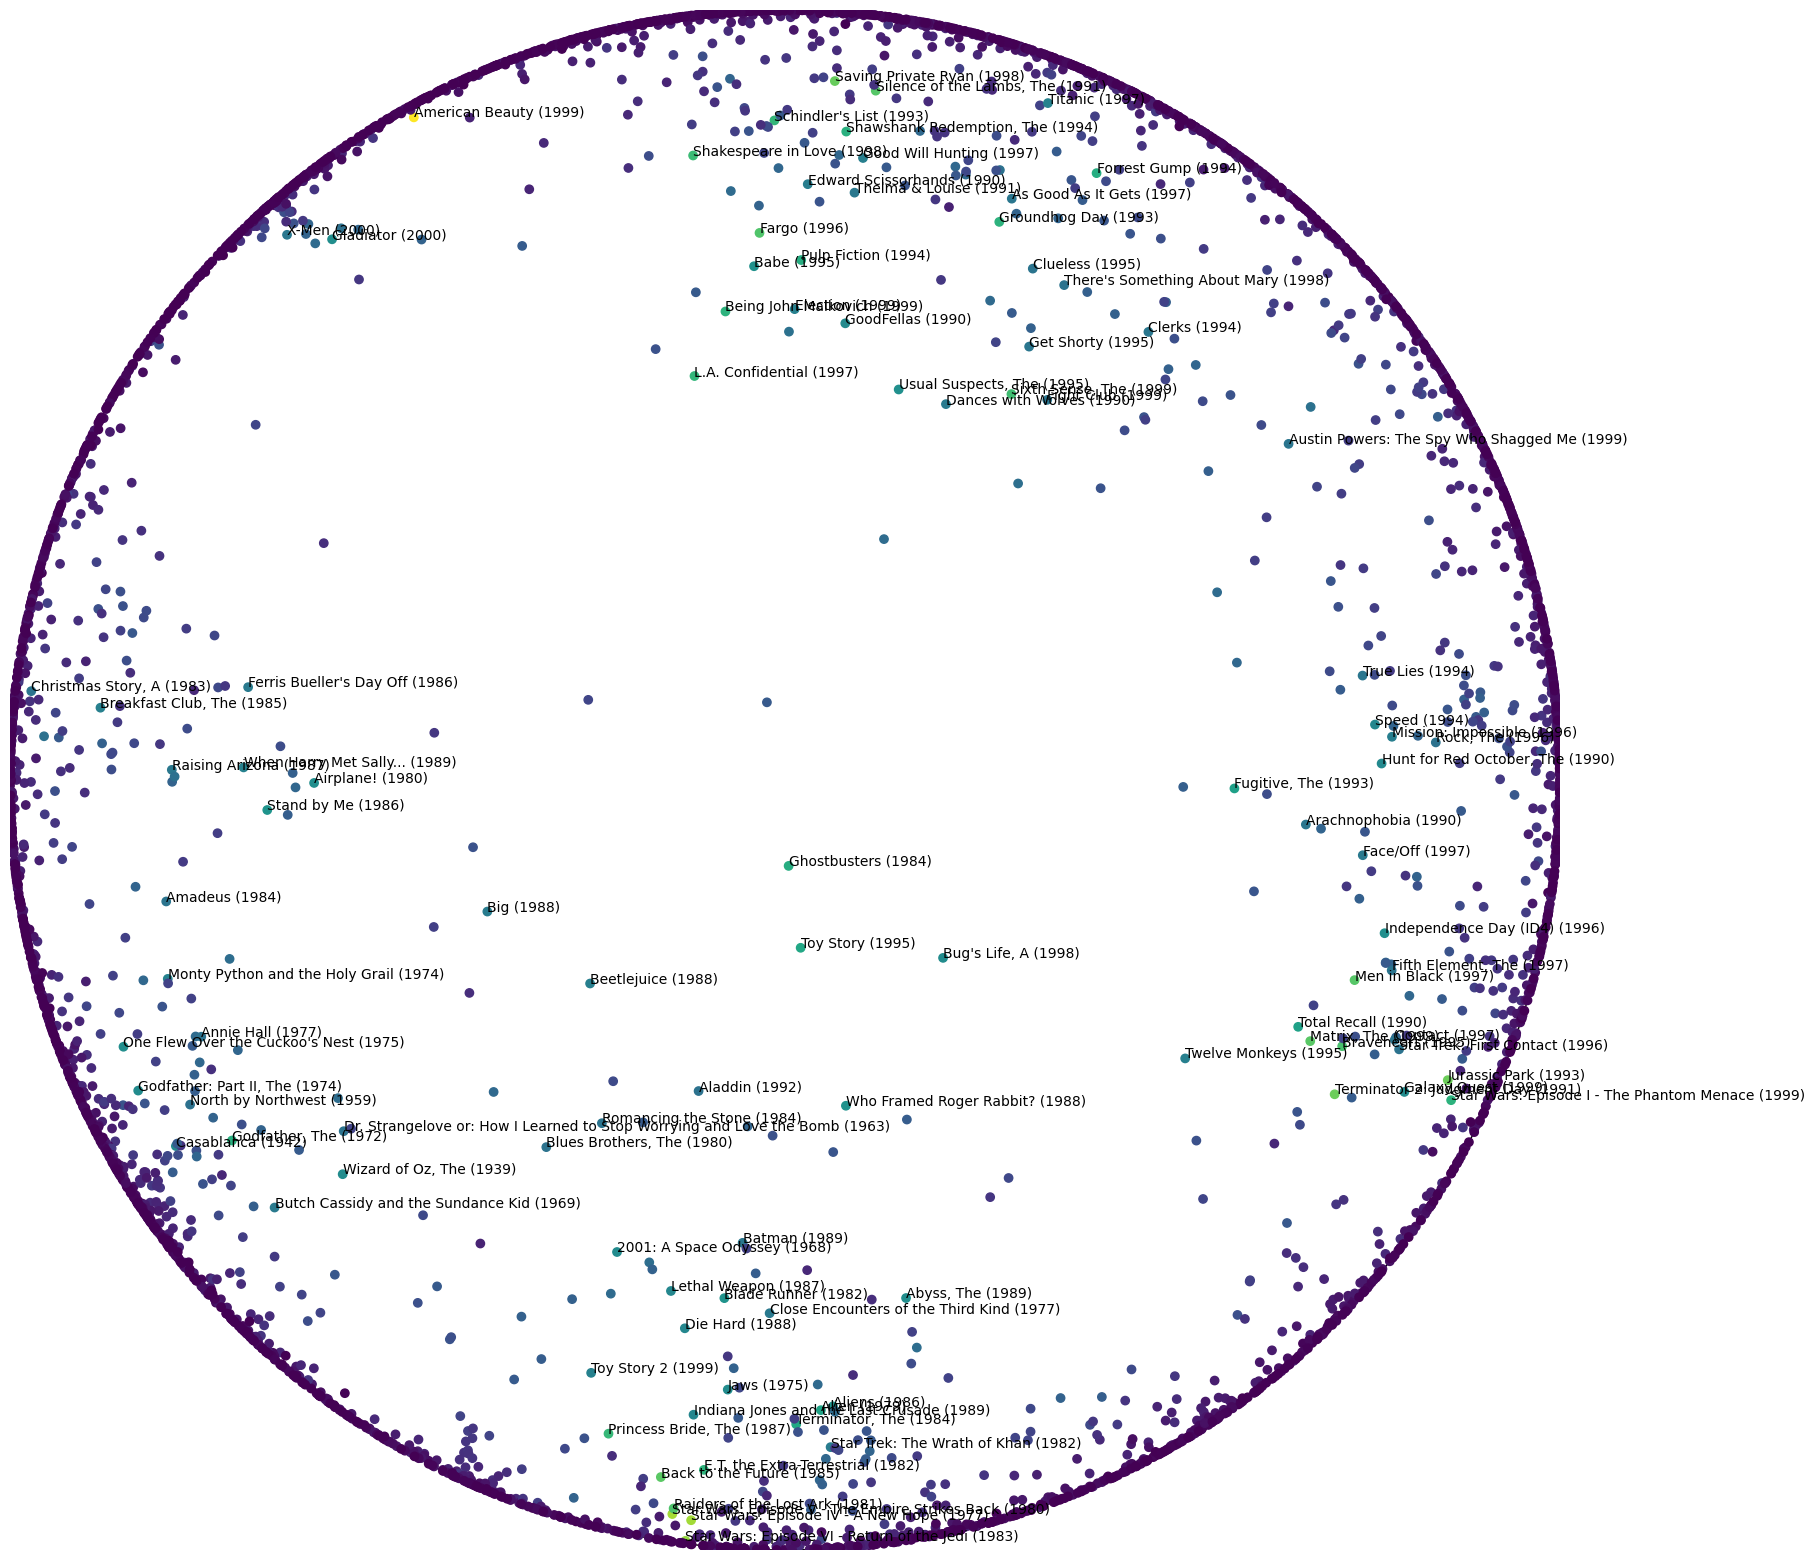

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))
# inds = item_data.sort_values(by=['item_id'])['item_id'].isin(torch.flip(torch.argsort(items_sims[398]), (0,))[:20].tolist()).values
indexes_to_draw = num_interactions[inds].argsort()[-100:]

embs = model.matrix
if isinstance(model.manifold, geoopt.Lorentz):
    embs = geoopt.manifolds.lorentz.math.lorentz_to_poincare(embs, model.manifold.k, dim=1)

for i in range(len(item_data.sort_values(by=['item_id'])[inds]['Title'].tolist())):
    if i not in indexes_to_draw:
        continue
    ax.annotate(
        item_data.sort_values(by=['item_id'])[inds]['Title'].tolist()[i],
        (embs[inds][i, 0].cpu().detach().numpy(), embs[inds][i, 1].cpu().detach().numpy())
    )

ax.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(-model.manifold.k), ec='black', fill=False))
ax.scatter(embs[inds, 0].cpu().detach().numpy(), embs[inds, 1].cpu().detach().numpy(), c=num_interactions[inds])
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_axis_off()

In [109]:
from src.frechetmean import frechet_mean,  Poincare

embs = model.matrix
if isinstance(model.manifold, geoopt.Lorentz):
    embs = geoopt.manifolds.lorentz.math.lorentz_to_poincare(embs, model.manifold.k, dim=1)

users_embs = frechet_mean(embs[None], Poincare(), interaction_matrix / num_interactions[None])

KeyboardInterrupt: 

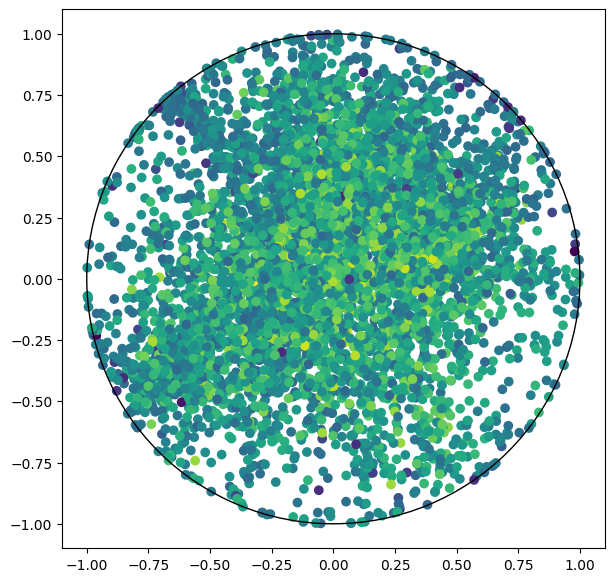

In [43]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(users_embs[:, 0].detach(), users_embs[:, 1].detach(), c=torch.sum(interaction_matrix, dim=1).detach(), norm='log')
ax.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(-model.manifold.k), ec='black', fill=False))

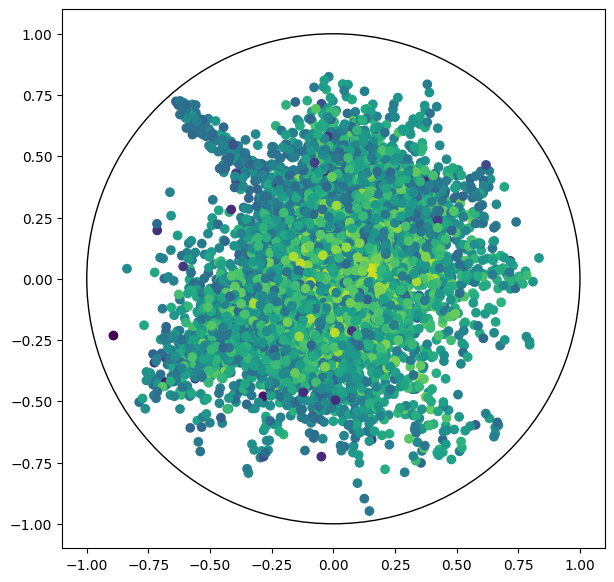

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(users_embs[:, 0].detach(), users_embs[:, 1].detach(), c=torch.sum(interaction_matrix, dim=1).detach(), norm='log')
ax.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(-model.manifold.k), ec='black', fill=False))

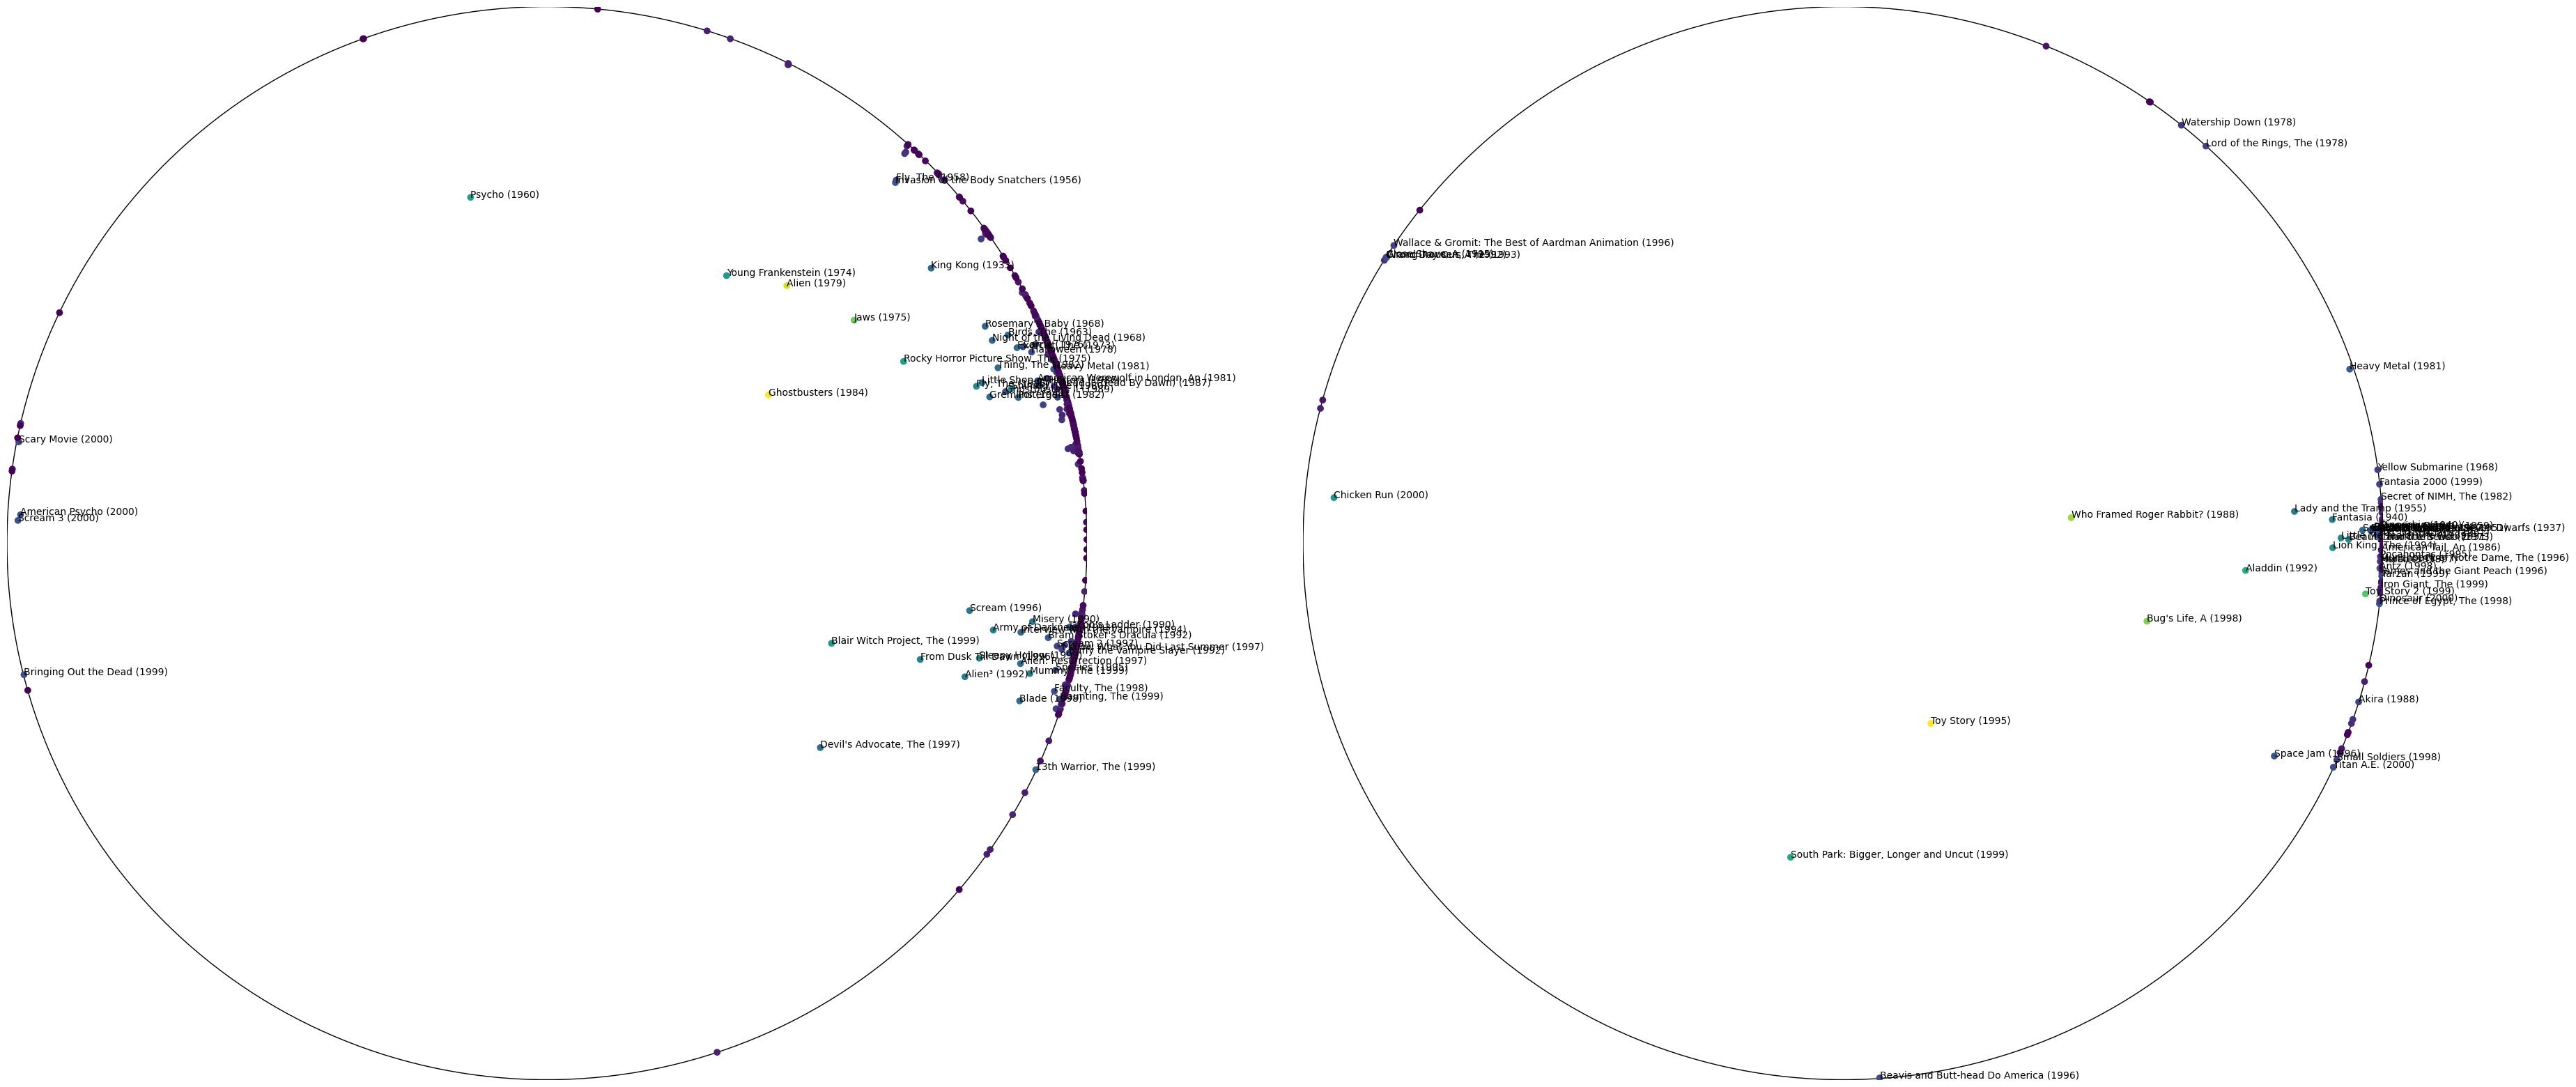

In [283]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(44, 20))
inds = item_data.sort_values(by=['item_id'])['Genres'].str.contains('Horror').values
indexes_to_draw = num_interactions[inds].argsort()[-50:]

for i in range(len(item_data.sort_values(by=['item_id'])[inds]['Title'].tolist())):
    if i not in indexes_to_draw:
        continue
    ax1.annotate(
        item_data.sort_values(by=['item_id'])[inds]['Title'].tolist()[i],
        (embs[inds][i, 0].cpu().detach().numpy(), embs[inds][i, 1].cpu().detach().numpy())
    )

ax1.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(model.manifold.k), ec='black', fill=False))
ax1.scatter(embs[inds, 0].cpu().detach().numpy(), embs[inds, 1].cpu().detach().numpy(), c=num_interactions[inds])
ax1.set_xlim(-1.0, 1.0)
ax1.set_ylim(-1.0, 1.0)
ax1.set_axis_off()

inds = item_data.sort_values(by=['item_id'])['Genres'].str.contains('Animation').values
indexes_to_draw = num_interactions[inds].argsort()[-50:]

for i in range(len(item_data.sort_values(by=['item_id'])[inds]['Title'].tolist())):
    if i not in indexes_to_draw:
        continue
    ax2.annotate(
        item_data.sort_values(by=['item_id'])[inds]['Title'].tolist()[i],
        (embs[inds][i, 0].cpu().detach().numpy(), embs[inds][i, 1].cpu().detach().numpy())
    )

ax2.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(model.manifold.k), ec='black', fill=False))
ax2.scatter(embs[inds, 0].cpu().detach().numpy(), embs[inds, 1].cpu().detach().numpy(), c=num_interactions[inds])
ax2.set_xlim(-1.0, 1.0)
ax2.set_ylim(-1.0, 1.0)
ax2.set_axis_off()
# plt.savefig('ml1m_embeddings.png')

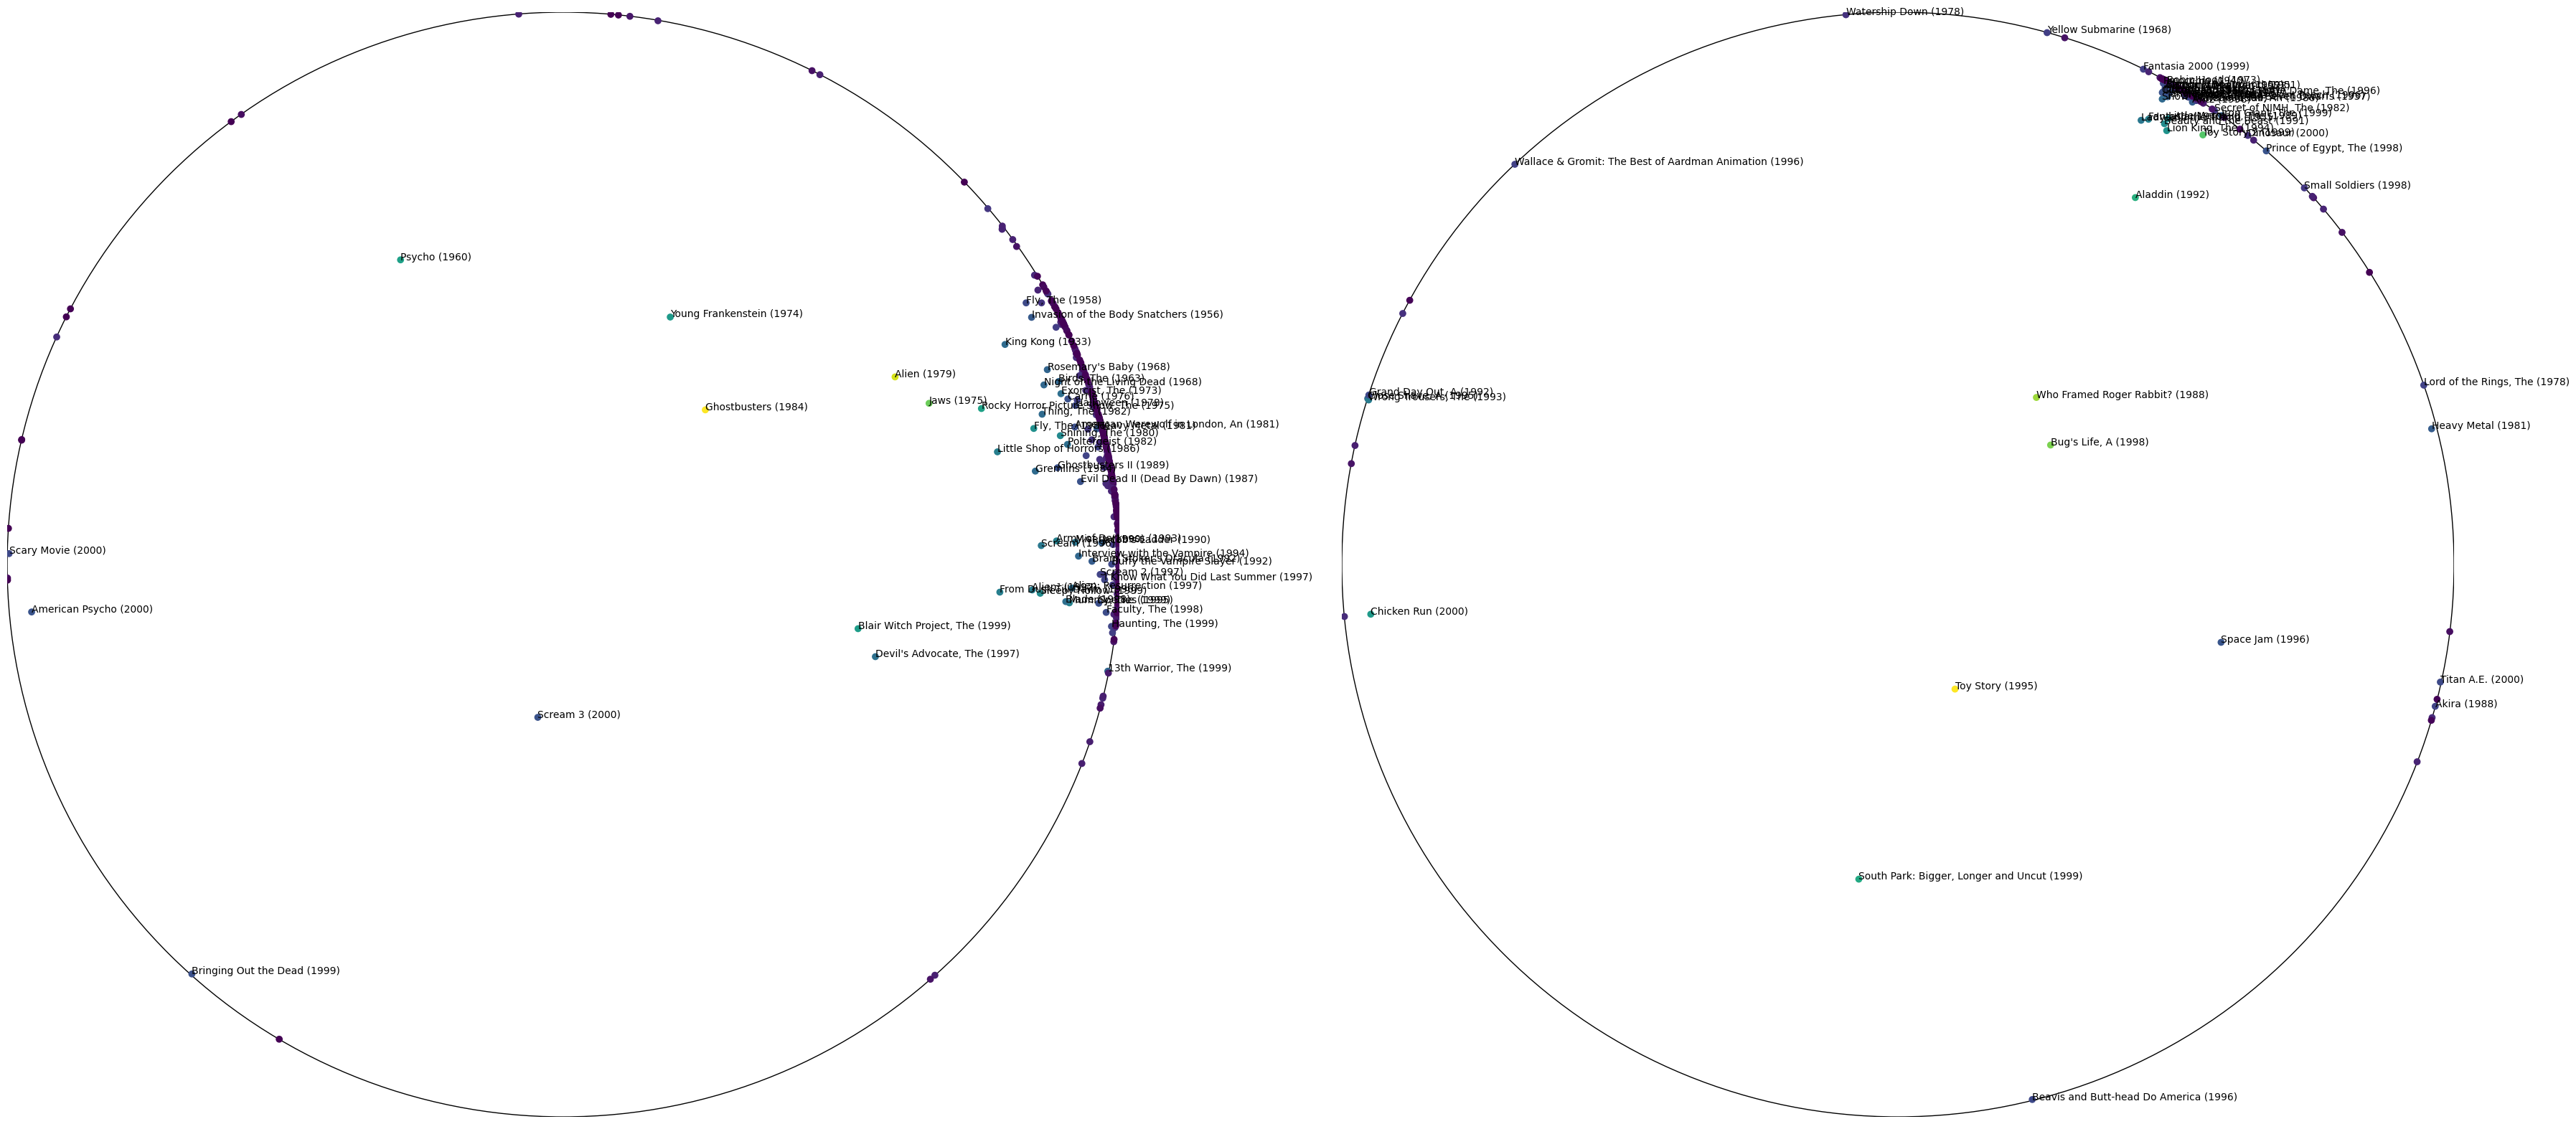

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(44, 20))
inds = item_data.sort_values(by=['item_id'])['Genres'].str.contains('Horror').values
indexes_to_draw = num_interactions[inds].argsort()[-50:]

for i in range(len(item_data.sort_values(by=['item_id'])[inds]['Title'].tolist())):
    if i not in indexes_to_draw:
        continue
    ax1.annotate(
        item_data.sort_values(by=['item_id'])[inds]['Title'].tolist()[i],
        (embs[inds][i, 0].cpu().detach().numpy(), embs[inds][i, 1].cpu().detach().numpy())
    )

ax1.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(model.manifold.k), ec='black', fill=False))
ax1.scatter(embs[inds, 0].cpu().detach().numpy(), embs[inds, 1].cpu().detach().numpy(), c=num_interactions[inds])
ax1.set_xlim(-1.0, 1.0)
ax1.set_ylim(-1.0, 1.0)
ax1.set_axis_off()

inds = item_data.sort_values(by=['item_id'])['Genres'].str.contains('Animation').values
indexes_to_draw = num_interactions[inds].argsort()[-50:]

for i in range(len(item_data.sort_values(by=['item_id'])[inds]['Title'].tolist())):
    if i not in indexes_to_draw:
        continue
    ax2.annotate(
        item_data.sort_values(by=['item_id'])[inds]['Title'].tolist()[i],
        (embs[inds][i, 0].cpu().detach().numpy(), embs[inds][i, 1].cpu().detach().numpy())
    )

ax2.add_patch(plt.Circle((0, 0), 1.0 / np.sqrt(model.manifold.k), ec='black', fill=False))
ax2.scatter(embs[inds, 0].cpu().detach().numpy(), embs[inds, 1].cpu().detach().numpy(), c=num_interactions[inds])
ax2.set_xlim(-1.0, 1.0)
ax2.set_ylim(-1.0, 1.0)
ax2.set_axis_off()
# plt.savefig('ml1m_embeddings.png')

In [27]:
torch.save(model.state_dict(), "model.pth")

In [28]:
%pwd

'/home/jupyter/work/resources'

In [215]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 14.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.8 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [218]:
%pip install datasets

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 63.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cloud-ml 0.0.1 requires requests<=2.28.1,>=2.22.0, but you have requests 2.32.3 which is incompatible.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 20.0.0 which is incompatible.
spacy 3.5.4 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have 

In [216]:
import transformers

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [220]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", name="raw_meta_Electronics")

Generating full split:  14%|█▍        | 229518/1610012 [01:12<05:00, 4600.44 examples/s] 